In [1]:
import os
from dotenv import load_dotenv

from datetime import datetime

from binance.client import Client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

2024-08-05 15:10:55.462339: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def create_previous_data_df(df, num_points):
    data_lists = []

    for i in range(len(df)):
        if i < num_points:
            continue
        
        prev_data = [df.iloc[i-n, 0] if i >= n else None for n in range(1, num_points+1)]
        data_lists.append(prev_data)

    columns = [f"X_{n}" for n in range(1, num_points+1)]
    prev_df = pd.DataFrame(data_lists, columns=columns)

    return prev_df

In [3]:
load_dotenv()
API_KEY    = os.getenv('API_KEY')
API_SECRET = os.getenv('API_SECRET')

client = Client(API_KEY, API_SECRET)

In [17]:
symbol = 'BTCUSDT'
interval = '1h'
window = 60

start_time = int(datetime(2020,1,1,0,0).timestamp() * 1000)
end_time   = int(datetime(2021,12,31,0,0).timestamp() * 1000)

In [5]:
kline = client.get_historical_klines(symbol=symbol, interval=interval, start_str=start_time, end_str=end_time)

In [6]:
columns = ['index', 'Close']
data = pd.DataFrame(kline)
data = data.iloc[:, [0, 4]]
data.columns  = columns
data['index'] = pd.to_datetime(data['index'], unit='ms')
data.set_index('index', inplace=True)
data = data.astype(float)
data['Return'] = data['Close'].shift(-1) / data['Close']
data = data.drop(columns=['Close'])
data.dropna(inplace=True)

In [7]:
data_train = data.iloc[:int(data.shape[0]*0.6), ]
data_test  = data.iloc[int(data.shape[0]*0.6):, ]

In [19]:
X_train = create_previous_data_df(data_train, window)
y_train = data_train['Return'].iloc[window:]

In [20]:
X_test = create_previous_data_df(data_test, window)
y_test = data_test['Return'].iloc[window:]

In [21]:
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_X_train = scaler.fit_transform(X_train)
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.array(y_train)

# scaled_X_test = scaler.fit_transform(X_test)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.array(y_test)

In [22]:
regressor = Sequential()

regressor.add(LSTM(units=50,
                   return_sequences=True,
                   input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,
                   return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,
                   return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

/Users/taryn.tsui/Documents/Alvin/GitHub/alvinlui99/Algo Trading/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
regressor.compile(optimizer='adam',
                  loss='mean_squared_error')
regressor.fit(X_train, y_train,
              epochs=20,
              batch_size=32)

Epoch 1/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 32s 78ms/step - loss: 0.0711
Epoch 2/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - loss: 0.0063
Epoch 3/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - loss: 0.0057
Epoch 4/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - loss: 0.0047
Epoch 5/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - loss: 0.0042
Epoch 6/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - loss: 0.0039
Epoch 7/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - loss: 0.0036
Epoch 8/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - loss: 0.0031
Epoch 9/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - loss: 0.0028
Epoch 10/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - loss: 0.0025
Epoch 11/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - loss: 0.0021
Epoch 12/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - loss: 0.0017
Epoch 13/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - loss: 0.0014
Epoch 14/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - loss: 0.0012
Epoch 15/20
327/327 ━━━━━━━━━

https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning

In [24]:
predicted = regressor.predict(X_test)

217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step


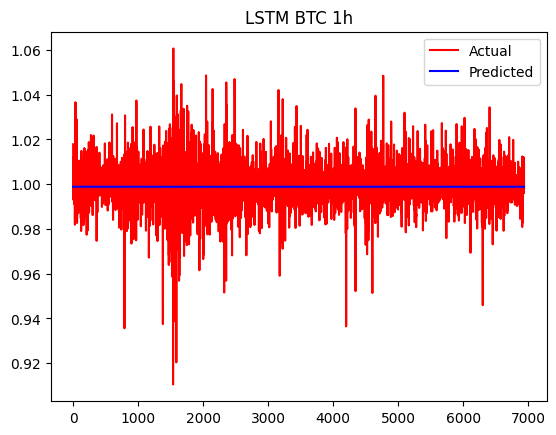

In [25]:
plt.plot(y_test, color='red', label='Actual')
plt.plot(predicted, color='blue', label='Predicted')
plt.title('LSTM BTC 1h')
plt.legend() 